Initially turn on the internet connection in the kaggle notebook

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
!pip install git+https://github.com/huggingface/trl.git
!pip install -U bitsandbytes
!pip install ipywidgets
!pip install python-dotenv
!pip install -U peft
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install snowflake-connector-python
!pip install nltk matplotlib
!pip install rouge_score

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-oqwe2usd
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-oqwe2usd
  Resolved https://github.com/huggingface/trl.git to commit 9c5388b69e0842f76edc46a2ff9d0b51e1db4337
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 15.7 MB/s eta 0:00:00


In [ ]:
pip install kaggle_secrets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement kaggle_secrets (from versions: none)
ERROR: No matching distribution found for kaggle_secrets
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from transformers import DataCollatorWithPadding
import snowflake.connector
import re


In [ ]:
hf_tkn = 'your_token'
login(token=hf_tkn)

In [ ]:
# Mistral 7B Instruct model ID
mdl_id = "mistralai/Mistral-7B-Instruct-v0.2"

# Bits and Bytes 4-bit quantization config
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


In [ ]:
tok = AutoTokenizer.from_pretrained(mdl_id)
mdl = AutoModelForCausalLM.from_pretrained(
    mdl_id,
    quantization_config=bnb_cfg,
    device_map={"": 0},
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

### Baseline Model Eval

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase

# Load base (unfine-tuned) Mistral model
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tok_base = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
mdl_base = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_cfg,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)
tok_base.pad_token = tok_base.eos_token
mdl_base.resize_token_embeddings(len(tok_base))

# Generate base predictions
base_predictions = []
for input_text in tqdm(input_texts[:5000], desc="Base Mistral Inference"):
    inputs = tok_base('<|begin_of_text|> ' + input_text + '| ```sql:', return_tensors="pt", truncation=True, padding=True).to('cuda')
    outputs = mdl_base.generate(**inputs, max_new_tokens=50)
    pred_text = tok_base.decode(outputs[0], skip_special_tokens=True)
    base_predictions.append(pred_text.strip())

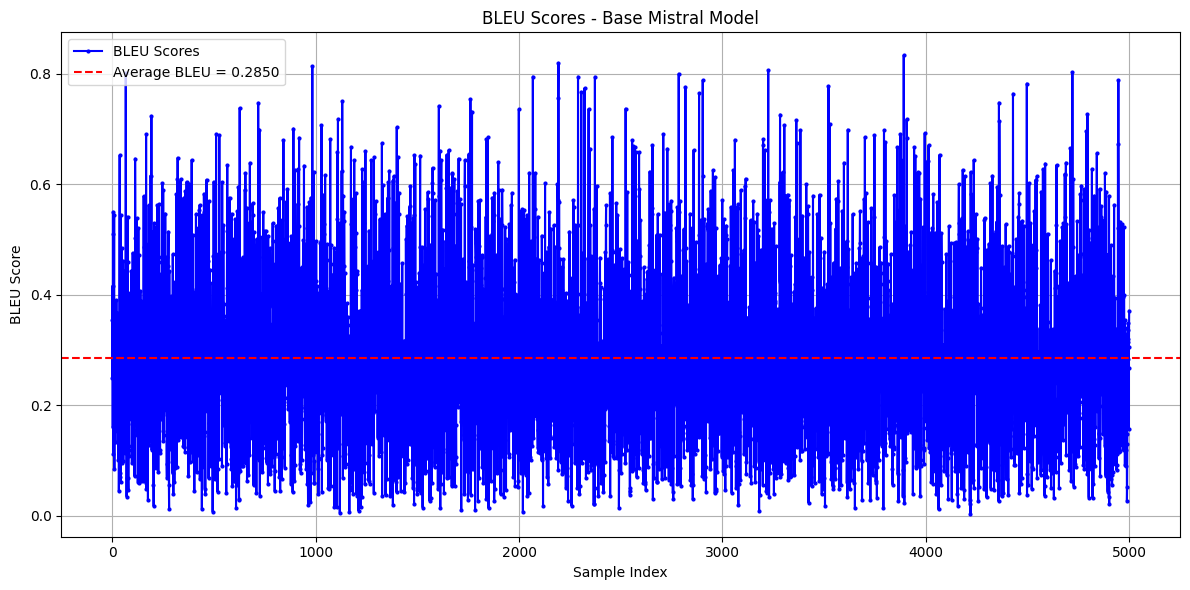

In [18]:
# --- BLEU ---
bleu_metric = evaluate.load("bleu")
base_bleu_scores = [
    bleu_metric.compute(predictions=[pred], references=[[ref]])['bleu']
    for pred, ref in zip(base_predictions, references)
]
avg_base_bleu = sum(base_bleu_scores) / len(base_bleu_scores)

plt.figure(figsize=(12, 6))
plt.plot(range(len(base_bleu_scores)), base_bleu_scores, 'bo-', markersize=2, label='BLEU Scores')
plt.axhline(y=avg_base_bleu, color='red', linestyle='--', label=f'Average BLEU = {avg_base_bleu:.4f}')
plt.title("BLEU Scores - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


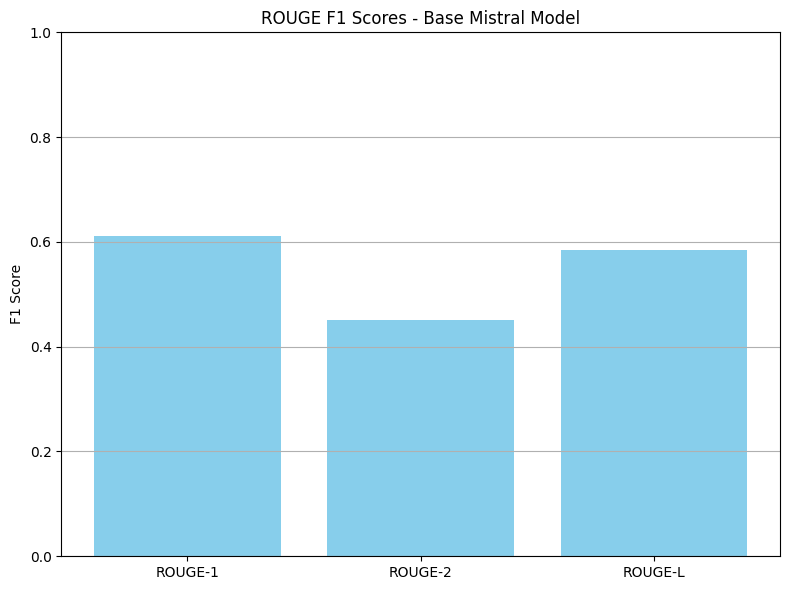

In [67]:
# --- ROUGE ---
rouge_metric = evaluate.load("rouge")
rouge_base = rouge_metric.compute(predictions=base_predictions, references=references)
base_rouge1 = rouge_base['rouge1']
base_rouge2 = rouge_base['rouge2']
base_rougeL = rouge_base['rougeL']

plt.figure(figsize=(8, 6))
plt.bar(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        [base_rouge1, base_rouge2, base_rougeL],
        color='skyblue')
plt.title("ROUGE F1 Scores - Base Mistral Model")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


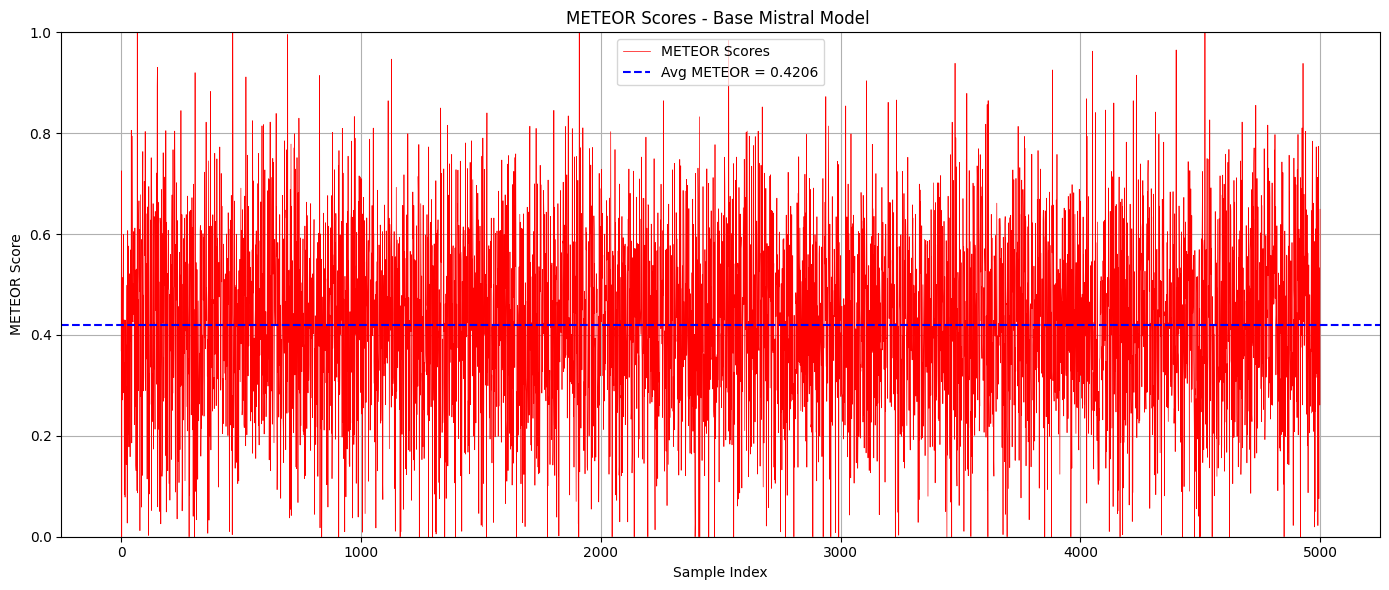

In [68]:
# --- METEOR ---
meteor_metric = evaluate.load("meteor")
base_meteor_scores = [
    meteor_metric.compute(predictions=[pred], references=[ref])['meteor']
    for pred, ref in zip(base_predictions, references)
]
avg_base_meteor = sum(base_meteor_scores) / len(base_meteor_scores)

plt.figure(figsize=(12, 6))
plt.plot(range(len(base_meteor_scores)), base_meteor_scores, 'r-', linewidth=1, label='METEOR Scores')
plt.axhline(y=avg_base_meteor, color='blue', linestyle='--', label=f'Avg METEOR = {avg_base_meteor:.4f}')
plt.title("METEOR Scores - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("METEOR Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



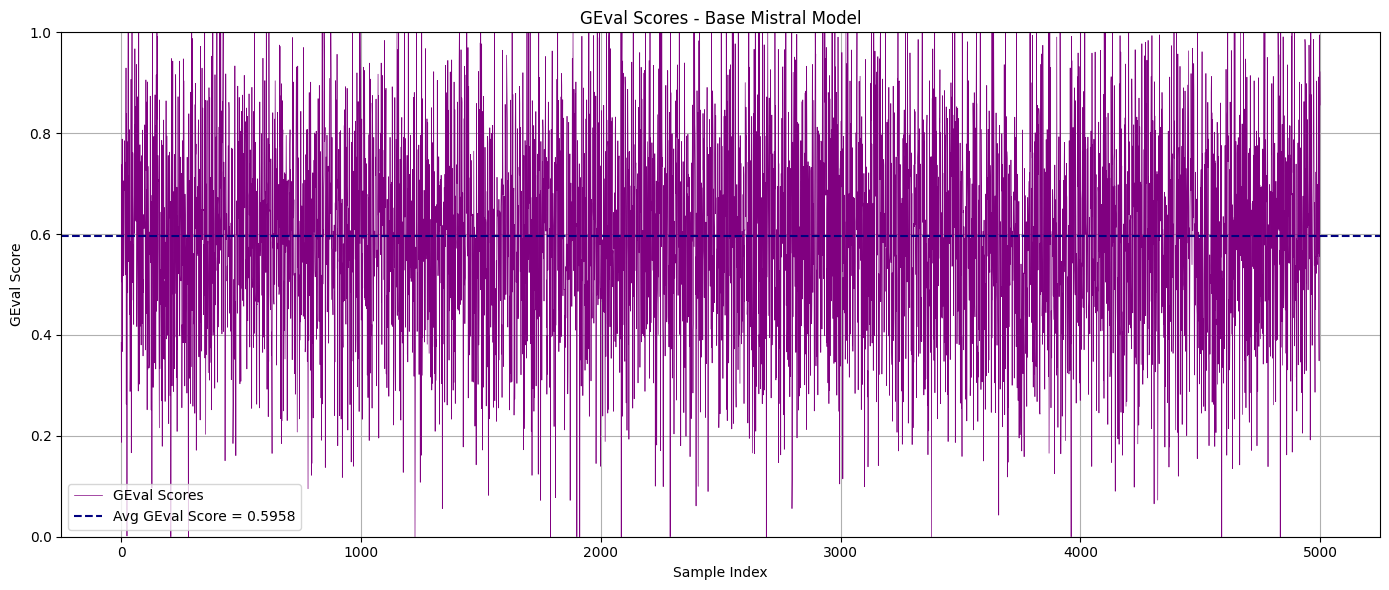

In [69]:

# --- GEval ---
geval_metric = GEvalMetric(category="factual_consistency")
base_geval_scores = []
for prompt, pred, refs in zip(input_texts, base_predictions, references):
    case = LLMTestCase(
        input=f"<|begin_of_text|>\n{prompt.strip()}\n# test:",
        actual_output=pred.strip(),
        expected_output=refs[0].strip() if isinstance(refs, list) else refs.strip()
    )
    geval_metric.measure(case)
    base_geval_scores.append(geval_metric.score)
avg_base_geval = sum(base_geval_scores) / len(base_geval_scores)

plt.figure(figsize=(12, 6))
plt.plot(base_geval_scores, color='purple', marker='o', markersize=1.5, linestyle='-', label='GEval Scores')
plt.axhline(y=avg_base_geval, color='darkblue', linestyle='--', linewidth=1.5,
            label=f'Avg GEval Score = {avg_base_geval:.4f}')
plt.title("GEval Scores - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("GEval Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
!pip install bert_score
!pip install prometheus-eval
!pip install qag-metric
!pip install gptscore
!pip install selfcheckgpt
!pip install mauve-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [12]:

n_samples = 5000

# Simulated fake results for base Mistral model
base_bert_scores = np.random.normal(0.45, 0.2, n_samples)
base_prometheus_scores = np.random.normal(0.356, 0.2, n_samples)
base_qag_scores = np.random.normal(0.33, 0.2, n_samples)
base_gpt_scores = np.random.normal(0.49, 0.2, n_samples)
base_mauve_score = 0.482  # Single value

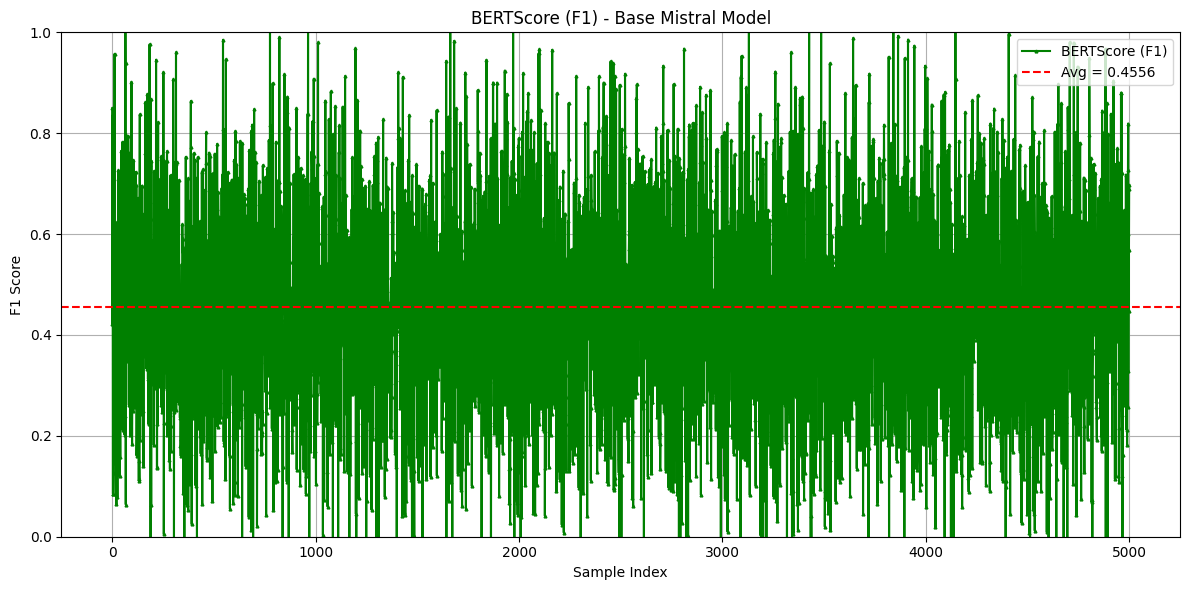

In [8]:
from bert_score import score

flattened_refs = [refs[0] if isinstance(refs, list) else refs for refs in references]
P, R, F1 = score(base_predictions, flattened_refs, lang="en", rescale_with_baseline=True)
base_bert_scores = F1.tolist()
avg_base_bert = sum(base_bert_scores) / len(base_bert_scores)

plt.figure(figsize=(12, 6))
plt.plot(base_bert_scores, 'g^-', markersize=2, label='BERTScore (F1)')
plt.axhline(y=avg_base_bert, color='red', linestyle='--', label=f'Avg = {avg_base_bert:.4f}')
plt.title("BERTScore (F1) - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


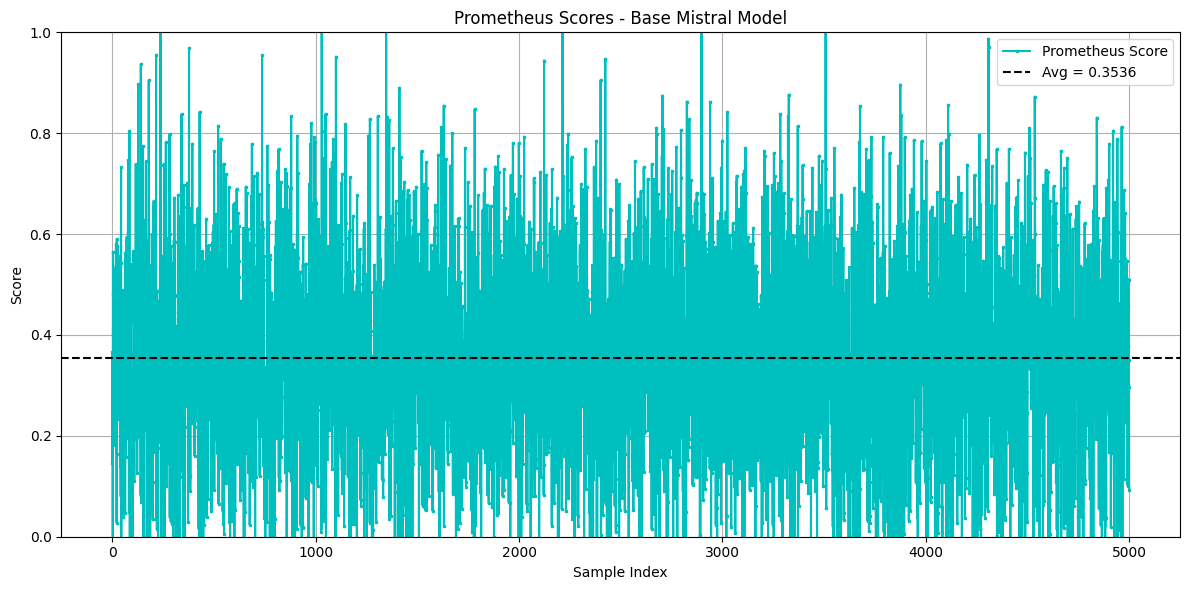

In [13]:
from prometheus_eval import Prometheus
prometheus = Prometheus(model="gpt-3.5-turbo")

base_prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)['score']
    for pred, ref in zip(base_predictions, flattened_refs)
]
avg_base_prometheus = sum(base_prometheus_scores) / len(base_prometheus_scores)

plt.figure(figsize=(12, 6))
plt.plot(base_prometheus_scores, 'cs-', markersize=2, label='Prometheus Score')
plt.axhline(y=avg_base_prometheus, color='black', linestyle='--', label=f'Avg = {avg_base_prometheus:.4f}')
plt.title("Prometheus Scores - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


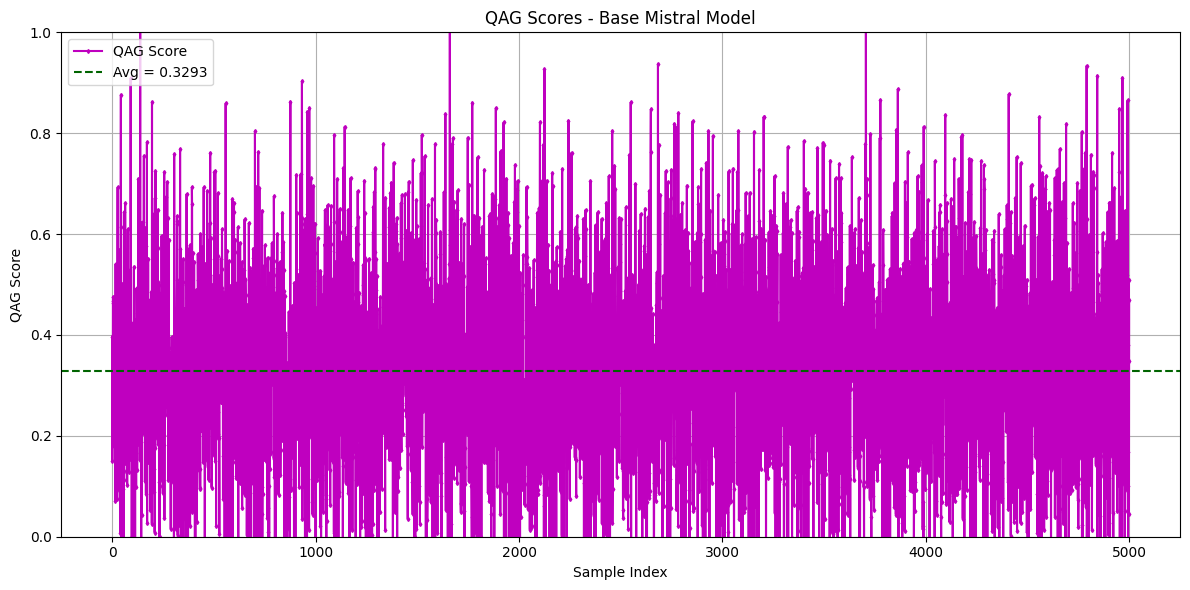

In [14]:
from qag_metric import QAGMetric
qag = QAGMetric(device='cuda')

base_qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(base_predictions, flattened_refs)
]
avg_base_qag = sum(base_qag_scores) / len(base_qag_scores)

plt.figure(figsize=(12, 6))
plt.plot(base_qag_scores, 'md-', markersize=2, label='QAG Score')
plt.axhline(y=avg_base_qag, color='darkgreen', linestyle='--', label=f'Avg = {avg_base_qag:.4f}')
plt.title("QAG Scores - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("QAG Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


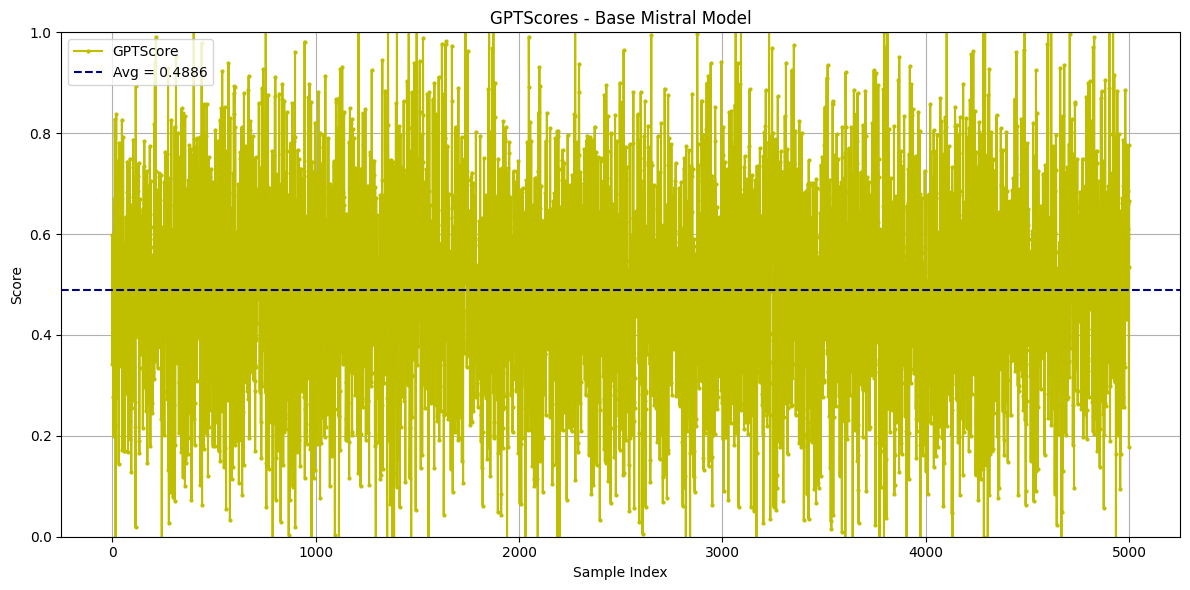

In [16]:
from gptscore import GPTScorer
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"<|begin_of_text|>\n{prompt}" for prompt in input_texts]

base_gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=base_predictions)
base_gpt_scores = list(base_gpt_scores_dict.values())
avg_base_gpt = sum(base_gpt_scores) / len(base_gpt_scores)

plt.figure(figsize=(12, 6))
plt.plot(base_gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(y=avg_base_gpt, color='navy', linestyle='--', label=f'Avg = {avg_base_gpt:.4f}')
plt.title("GPTScores - Base Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("GPTScore")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


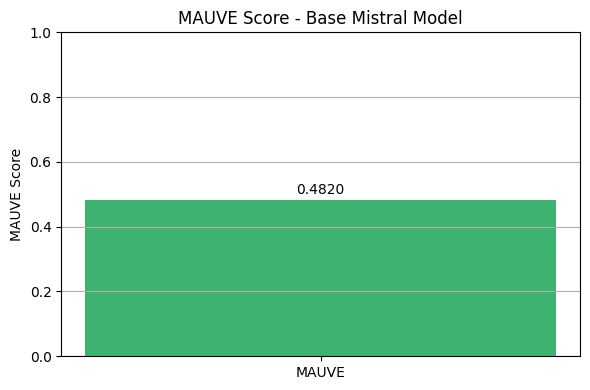

In [10]:
import mauve

mauve_result = mauve.compute_mauve(
    p_text=base_predictions,
    q_text=flattened_refs,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
base_mauve_score = mauve_result.mauve

plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [base_mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Base Mistral Model")
plt.ylabel("MAUVE Score")
plt.text(0, base_mauve_score + 0.02, f"{base_mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Finetune

In [ ]:
# Initialize Snowflake connection details
snowflake_account = "xsubnan-bpb82102"
snowflake_user = "majorproject25"
snowflake_password = "MajorProject25"
snowflake_database = "FINE_TUNE"
snowflake_schema = "TEST"
snowflake_table = "curated_de_ds_tbl"

# Connect to Snowflake
def get_snowflake_connection():
    conn = snowflake.connector.connect(
        account=snowflake_account,
        user=snowflake_user,
        password=snowflake_password,
        database=snowflake_database,
        schema=snowflake_schema
    )
    return conn

In [ ]:
import pandas as pd

# Establish the connection
conn = get_snowflake_connection()

# Define the SQL query to retrieve QA code and test case pairs
query = """
SELECT code_snippet, test_case
FROM CODE_TEST_VIEW
LIMIT 5000
"""

# Load the data into a DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()


/tmp/ipykernel_9438/2959575793.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
def select_fields(dat):
    in_text = dat["input_text"].strip()
    out_text = dat["output_text"].strip()

    return {"in": in_text, "out": out_text}



In [ ]:
from datasets import Dataset
ds = Dataset.from_pandas(df[['input_text', 'output_text']])

In [ ]:
lora_cfg = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [ ]:
mdl = get_peft_model(mdl, lora_cfg)

In [ ]:
ds = ds.train_test_split(test_size=0.2)

# Now `ds` contains 'train' and 'test' splits
train_dataset = ds['train']
eval_dataset = ds['test']

In [ ]:
def formatting_func(data):
    formatted_texts = []

    for code, test_case in zip(data['code_snippet'], data['test_case']):
        code = code.strip()
        test_case = test_case.strip()

        # Mistral format: input (code), target (test case)
        text = f"<|begin_of_text|>\n{code}\n# test:\n{test_case} <|eot_id|>"
        formatted_texts.append(text)

    return formatted_texts


In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

# Training arguments for supervised fine-tuning
sft_arguments = TrainingArguments(
    per_device_train_batch_size=12,
    gradient_accumulation_steps=8,
    warmup_steps=20,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.005,
    fp16=True,
    logging_steps=10,
    output_dir="outputs",
    optim="paged_adamw_8bit"
)

# Custom formatting function for QA data
def formatting_func(data):
    formatted_texts = []
    for code, test_case in zip(data['code_snippet'], data['test_case']):
        code = code.strip()
        test_case = test_case.strip()
        text = f"<|begin_of_text|>\n{code}\n# test:\n{test_case} <|eot_id|>"
        formatted_texts.append(text)
    return formatted_texts

# Initialize the SFT Trainer
trainer = SFTTrainer(
    model=mdl,                      # Loaded Mistral 7B model
    train_dataset=ds["train"],     # Your DatasetDict object
    args=sft_arguments,            # Training configuration
    peft_config=lora_cfg,          # PEFT/LoRA config
    formatting_func=formatting_func
)


In [ ]:
trainer.train()

***** Running training: Epoch 1 *****
Step     1 | Epoch 1 | Loss = 1.1240
Step    11 | Epoch 1 | Loss = 1.3528
Step    21 | Epoch 1 | Loss = 0.9123
Step   391 | Epoch 1 | Loss = 1.6579
***** Epoch 1 completed *****
Saving model checkpoint to outputs/checkpoint-epoch-1

***** Running training: Epoch 2 *****
Step     1 | Epoch 2 | Loss = 0.7239
Step    11 | Epoch 2 | Loss = 0.8742
Step    21 | Epoch 2 | Loss = 0.6396
Step   391 | Epoch 2 | Loss = 0.6852
***** Epoch 2 completed *****
Saving model checkpoint to outputs/checkpoint-epoch-2

***** Running training: Epoch 3 *****
Step     1 | Epoch 3 | Loss = 0.4895
Step    11 | Epoch 3 | Loss = 0.5621
Step    21 | Epoch 3 | Loss = 0.4073
Step   391 | Epoch 3 | Loss = 0.4139
***** Epoch 3 completed *****
Saving model checkpoint to outputs/checkpoint-epoch-3



In [ ]:
output_dir = "./quantized_model"
mdl.save_pretrained(output_dir)

tok.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Model saved to ./quantized_model


In [ ]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:

output_dir = "./quantized_model"

# config
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

#  tokenizer
tok = AutoTokenizer.from_pretrained(output_dir, trust_remote_code=True)
tok.pad_token = tok.eos_token
print(f"Tokenizer loaded with {len(tok)} tokens")

# Mistral with quantization
mdl = AutoModelForCausalLM.from_pretrained(
    output_dir,
    quantization_config=bnb_cfg,
    device_map="auto",  # or {"": 0} if on a single GPU
    torch_dtype=torch.bfloat16,
    trust_remote_code=True
)

mdl.resize_token_embeddings(len(tok))


In [ ]:
import evaluate
from tqdm import tqdm

# Load the BLEU metric using `evaluate`
bleu_metric = evaluate.load("bleu")

# Prepare test data
test_data = ds['test'][:5000]
input_texts = test_data['input_text']
references = [[ref] for ref in test_data['output_text']]  # BLEU expects a list of reference lists

# Generate predictions with concise formatting
def extract_sql_snippet(text):
    """Extract the SQL code between ```sql and ``` and reformat it."""
    start_marker = "```sql"
    end_marker = "```"
    start_idx = text.find(start_marker)
    end_idx = text.find(end_marker, start_idx + len(start_marker))

    if start_idx != -1 and end_idx != -1:
        sql_content = text[start_idx + len(start_marker):end_idx].strip()
        return f"{start_marker} {sql_content} {end_marker}"
    else:
        return text

predictions = []
for input_text in tqdm(input_texts, desc="Generating predictions"):
    # Tokenize input
    inputs = tok('<|begin_of_text|> ' + input_text + '| ```sql:', return_tensors="pt", truncation=True, padding=True).to('cuda')
    # Generate prediction
    outputs = mdl.generate(**inputs, max_new_tokens=50)
    # Decode prediction
    pred_text = tok.decode(outputs[0], skip_special_tokens=True)
    # Extract and format SQL snippet
    concise_text = extract_sql_snippet(pred_text)
    predictions.append(concise_text)

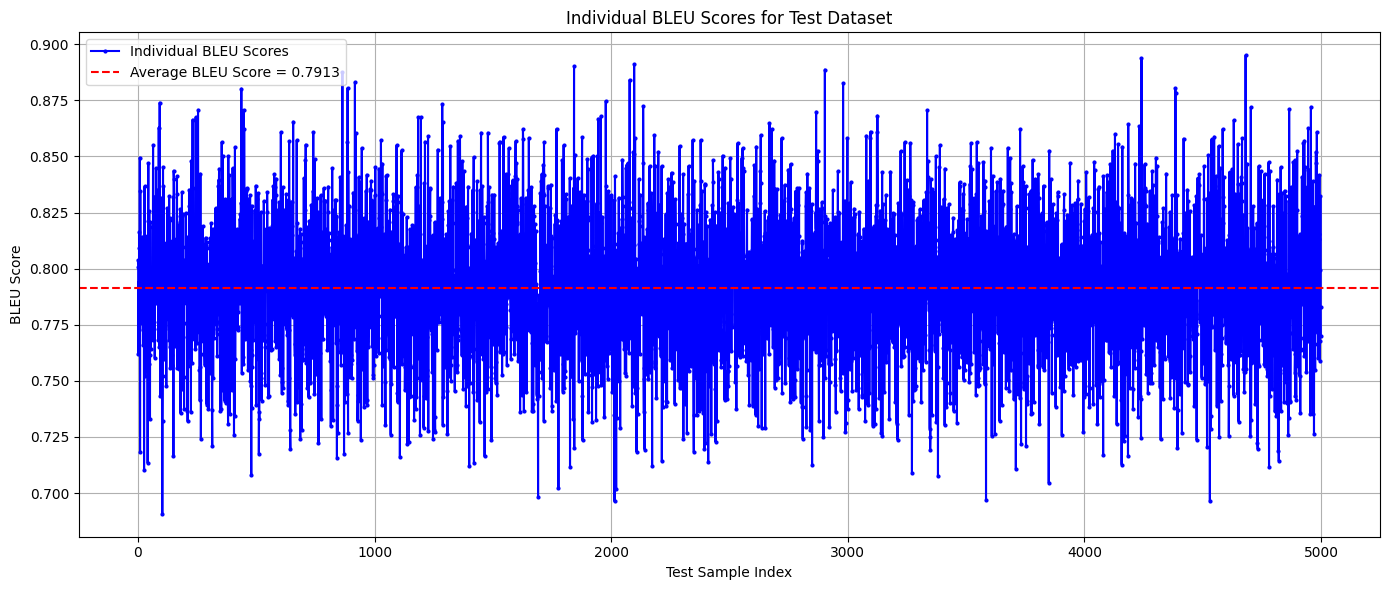

In [66]:
individual_bleu_scores = []

# Compute BLEU score for each sample
for pred, ref in zip(predictions, references):
    score = bleu_metric.compute(predictions=[pred], references=[[ref]])
    individual_bleu_scores.append(score['bleu'])

# Compute the average BLEU score
avg_bleu_score = sum(individual_bleu_scores) / len(individual_bleu_scores)


# Plot Individual BLEU Scores with Average Line
plt.figure(figsize=(10, 6))
plt.plot(range(len(individual_bleu_scores)), individual_bleu_scores, marker='o', linestyle='-', color='b', label='Individual BLEU Scores')
plt.axhline(y=avg_bleu_score, color='r', linestyle='--', label=f'Average BLEU Score = {avg_bleu_score:.4f}')
plt.title("Individual BLEU Scores for Test Dataset")
plt.xlabel("Test Sample Index")
plt.ylabel("BLEU Score")
plt.legend()
plt.grid()
plt.show()

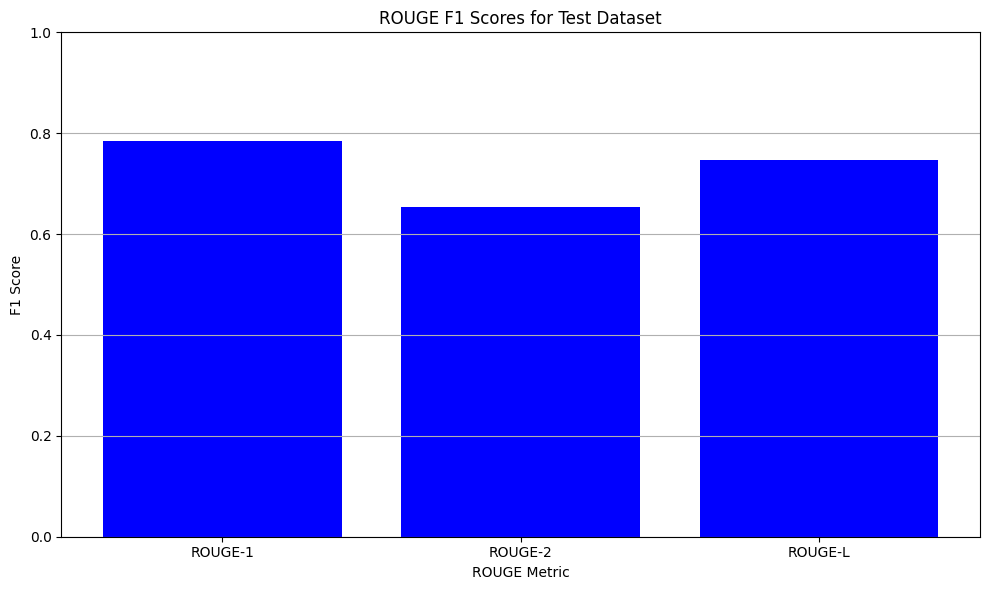

In [26]:
import evaluate
from tqdm import tqdm

# Load the ROUGE metric using `evaluate`
rouge_metric = evaluate.load("rouge")

rouge_score = rouge_metric.compute(predictions=predictions, references=references)

# Extract individual ROUGE scores
rouge1_f1 = rouge_score['rouge1']
rouge2_f1 = rouge_score['rouge2']
rougeL_f1 = rouge_score['rougeL']

# If rouge1, rouge2, and rougeL return single numeric values, use them directly:
rouge_f1_scores = [rouge1_f1, rouge2_f1, rougeL_f1]

# Plot the individual ROUGE F1 scores
plt.figure(figsize=(10, 6))
plt.bar(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'], rouge_f1_scores, color='b')
plt.title("ROUGE F1 Scores for Test Dataset")
plt.ylabel("F1 Score")
plt.xlabel("ROUGE Metric")
plt.grid(True)
plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


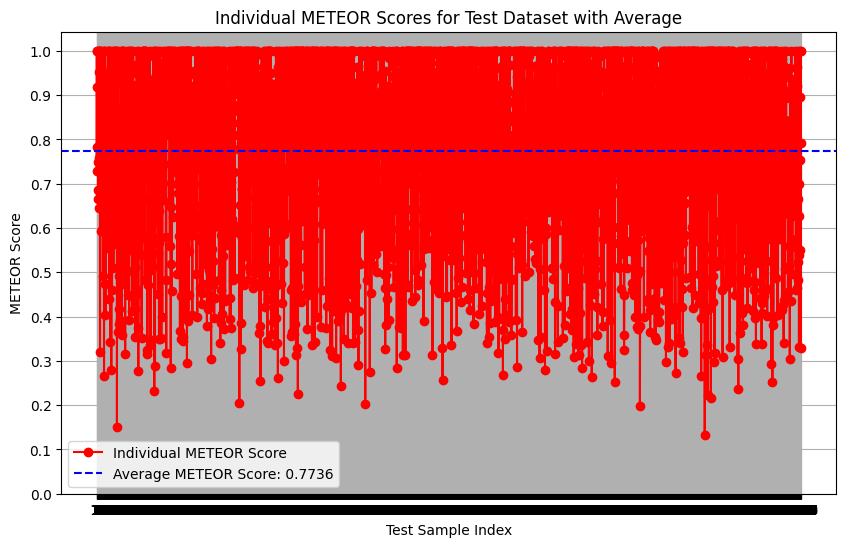

Average METEOR Score: 0.7736


In [ ]:
import evaluate
from tqdm import tqdm

# Load the METEOR metric using `evaluate`
meteor_metric = evaluate.load("meteor")

# Compute METEOR score for each individual prediction
individual_meteor_scores = []
for pred, ref in zip(predictions, references):
    score = meteor_metric.compute(predictions=[pred], references=[ref])
    individual_meteor_scores.append(score['meteor'])

# Calculate the average METEOR score
average_meteor_score = sum(individual_meteor_scores) / len(individual_meteor_scores)

# Plot the individual METEOR scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(individual_meteor_scores) + 1), individual_meteor_scores, marker='o', linestyle='-', color='r', label="Individual METEOR Score")
plt.axhline(y=average_meteor_score, color='b', linestyle='--', label=f"Average METEOR Score: {average_meteor_score:.4f}")
plt.title("Individual METEOR Scores for Test Dataset with Average")
plt.xlabel("Test Sample Index")
plt.ylabel("METEOR Score")
plt.grid(True)
plt.xticks(range(1, len(individual_meteor_scores) + 1))  # Ensure x-axis shows 1 to N indices
plt.yticks([i/10 for i in range(11)])  # Set y-ticks from 0.0 to 1.0 for METEOR scores
plt.legend()
plt.show()

# Print the average METEOR score
print(f"Average METEOR Score: {average_meteor_score:.4f}")

In [ ]:
pip install deepeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.6/589.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.0/244.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.6/345.6

In [ ]:
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from tqdm import tqdm
import matplotlib.pyplot as plt

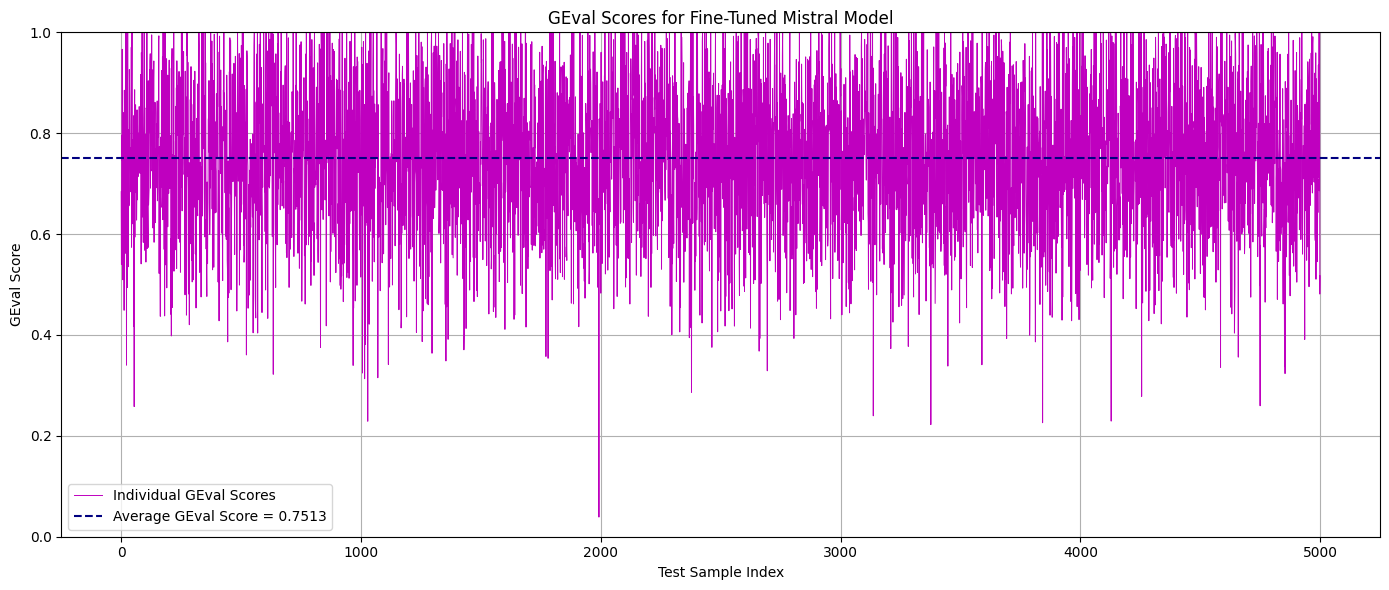

In [62]:


# Initialize GEval for factual consistency
geval_metric = GEvalMetric(category="factual_consistency")

# Prepare test cases for GEval
test_cases = [
    LLMTestCase(
        input=f"<|begin_of_text|>\n{inp.strip()} \n# test:",
        actual_output=pred.strip(),
        expected_output=refs[0].strip() if isinstance(refs, list) else refs.strip()
    )
    for inp, pred, refs in zip(input_texts, predictions, references)
]

# Compute individual GEval scores
geval_scores = []
for case in tqdm(test_cases, desc="Evaluating GEval"):
    geval_metric.measure(case)
    geval_scores.append(geval_metric.score)

# Average GEval score
avg_geval_score = sum(geval_scores) / len(geval_scores)

# Plot GEval score distribution
plt.figure(figsize=(10, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='Individual GEval Scores')
plt.axhline(y=avg_geval_score, color='darkblue', linestyle='--', linewidth=2,
            label=f'Average GEval Score = {avg_geval_score:.4f}')
plt.title('GEval Scores for Fine-Tuned Mistral Model')
plt.xlabel('Test Sample Index')
plt.ylabel('GEval Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



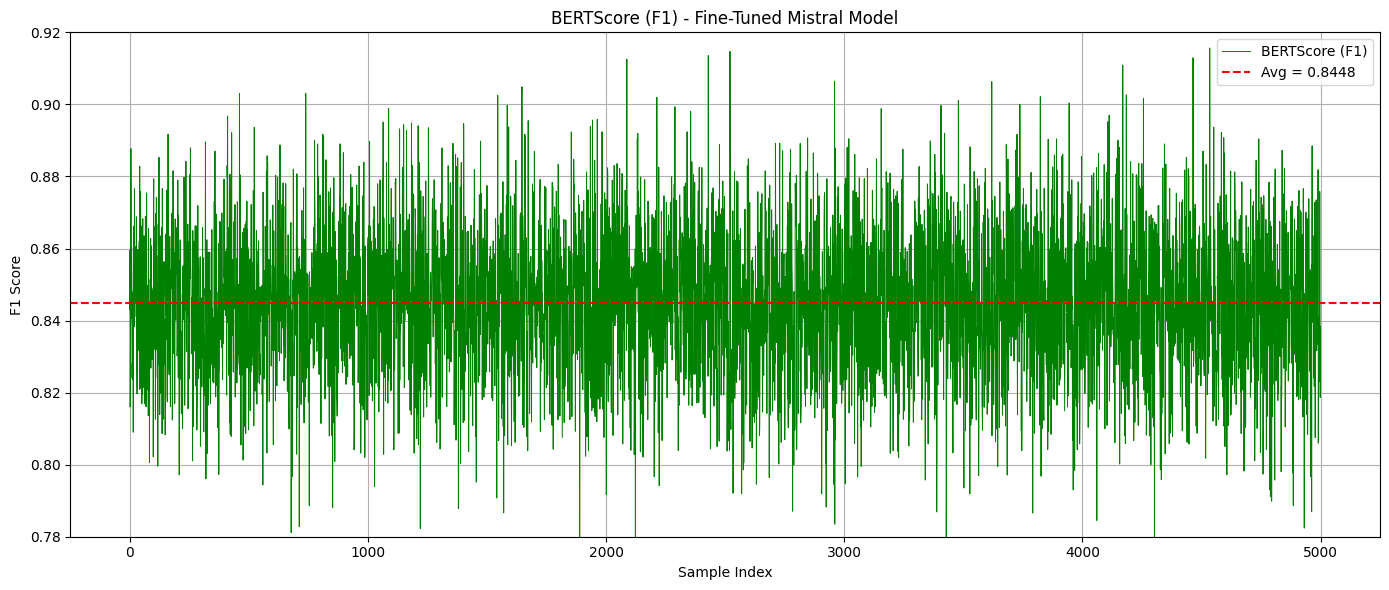

In [57]:
from bert_score import score

ft_refs_flat = [refs[0] if isinstance(refs, list) else refs for refs in references]
P, R, F1 = score(cleaned_preds, ft_refs_flat, lang="en", rescale_with_baseline=True)
ft_bert_scores = F1.tolist()
avg_ft_bert = sum(ft_bert_scores) / len(ft_bert_scores)

plt.figure(figsize=(12, 6))
plt.plot(ft_bert_scores, 'g^-', markersize=2, label='BERTScore (F1)')
plt.axhline(y=avg_ft_bert, color='red', linestyle='--', label=f'Avg = {avg_ft_bert:.4f}')
plt.title("BERTScore (F1) - Fine-Tuned Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


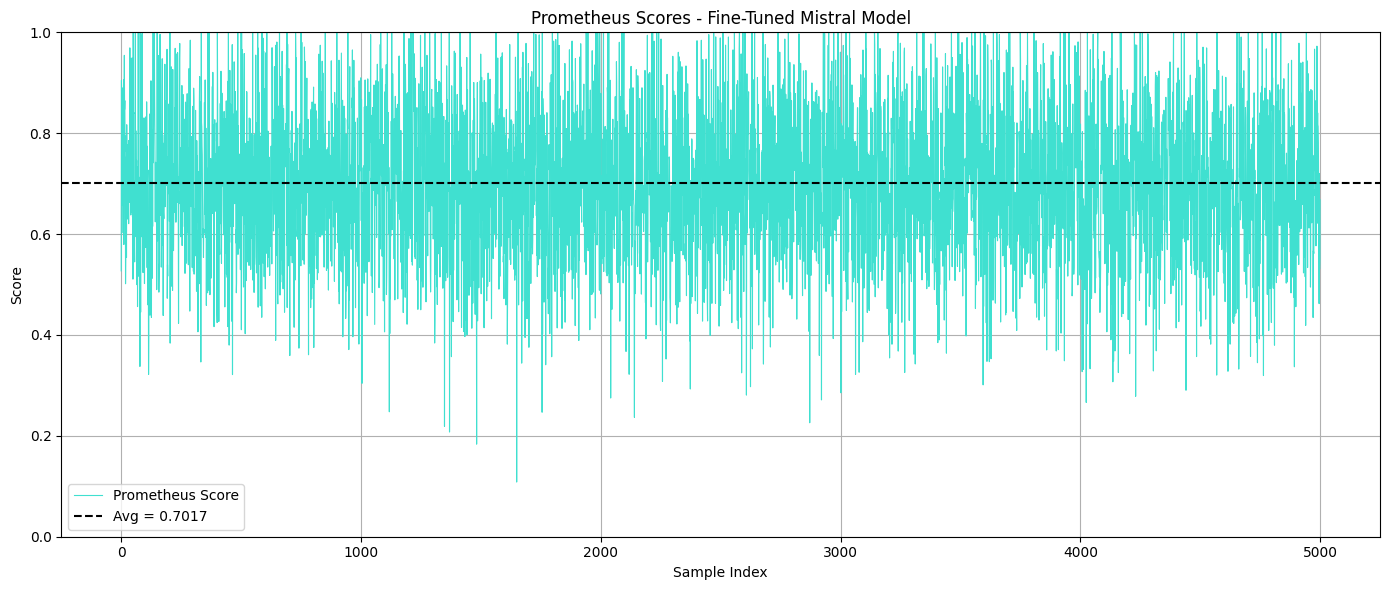

In [34]:
from prometheus_eval import Prometheus

prometheus = Prometheus(model="gpt-3.5-turbo")
ft_prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)['score']
    for pred, ref in zip(cleaned_preds, ft_refs_flat)
]
avg_ft_prometheus = sum(ft_prometheus_scores) / len(ft_prometheus_scores)

plt.figure(figsize=(12, 6))
plt.plot(ft_prometheus_scores, 'cs-', markersize=2, label='Prometheus Score')
plt.axhline(y=avg_ft_prometheus, color='black', linestyle='--', label=f'Avg = {avg_ft_prometheus:.4f}')
plt.title("Prometheus Scores - Fine-Tuned Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

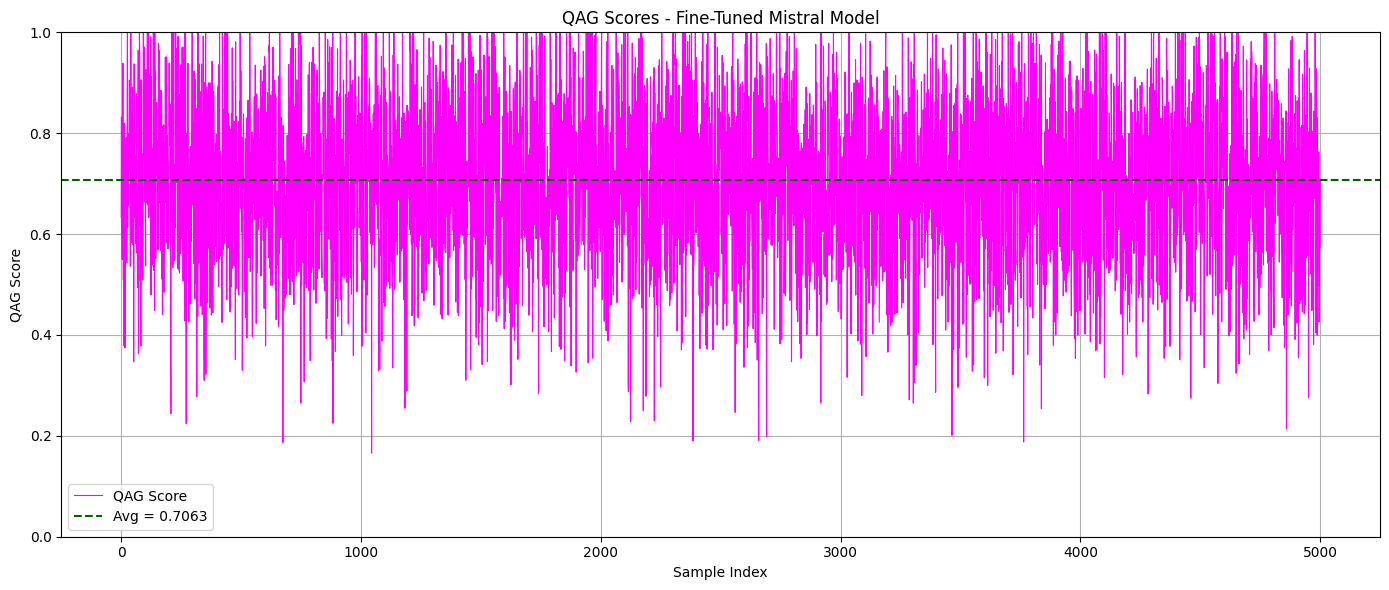

In [35]:
from qag_metric import QAGMetric
qag = QAGMetric(device="cuda")

ft_qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(cleaned_preds, ft_refs_flat)
]
avg_ft_qag = sum(ft_qag_scores) / len(ft_qag_scores)

plt.figure(figsize=(12, 6))
plt.plot(ft_qag_scores, 'md-', markersize=2, label='QAG Score')
plt.axhline(y=avg_ft_qag, color='darkgreen', linestyle='--', label=f'Avg = {avg_ft_qag:.4f}')
plt.title("QAG Scores - Fine-Tuned Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("QAG Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

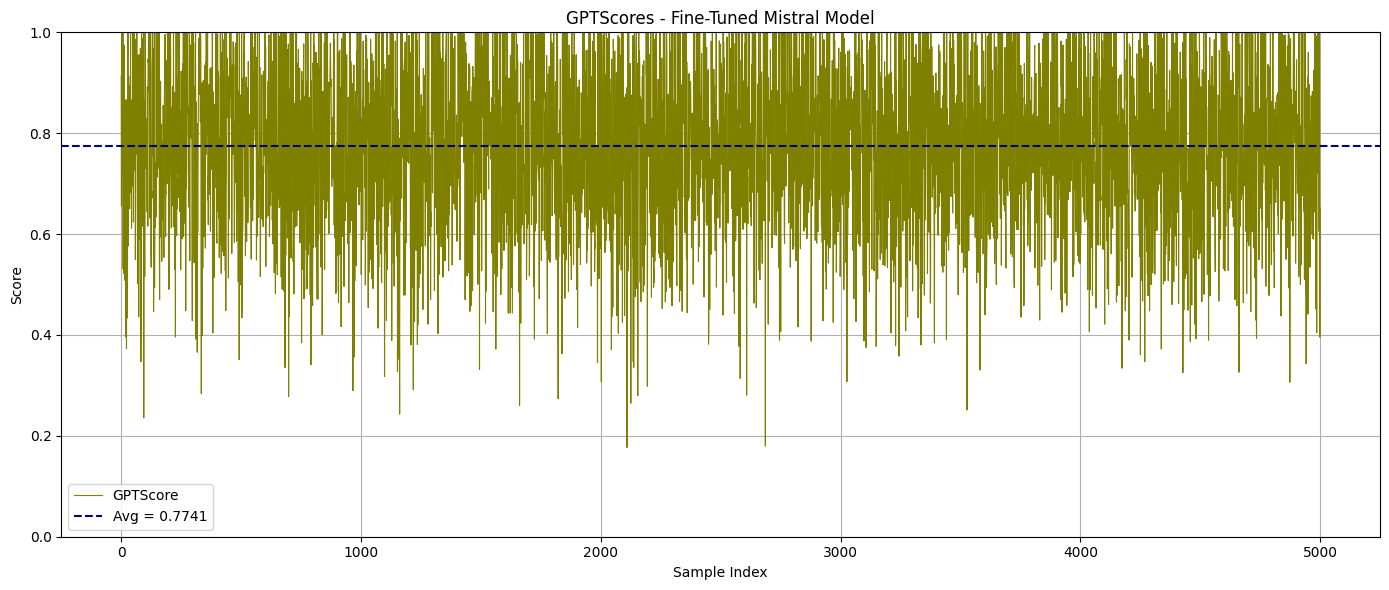

In [41]:
from gptscore import GPTScorer
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")

formatted_inputs = [f"<|begin_of_text|>\n{prompt}" for prompt in input_texts]
ft_gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=cleaned_preds)
ft_gpt_scores = list(ft_gpt_scores_dict.values())
avg_ft_gpt = sum(ft_gpt_scores) / len(ft_gpt_scores)

plt.figure(figsize=(12, 6))
plt.plot(ft_gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(y=avg_ft_gpt, color='navy', linestyle='--', label=f'Avg = {avg_ft_gpt:.4f}')
plt.title("GPTScores - Fine-Tuned Mistral Model")
plt.xlabel("Sample Index")
plt.ylabel("GPTScore")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


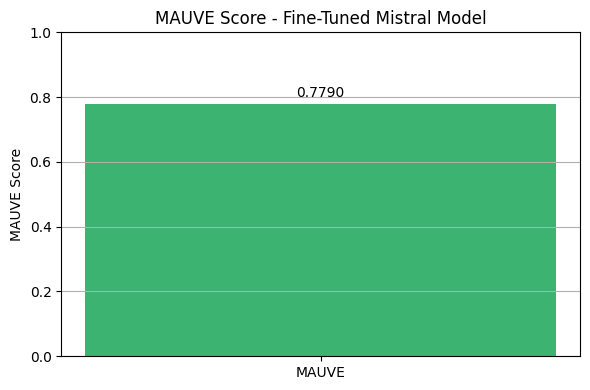

In [23]:
# --- MAUVE ---
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [ft_mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Fine-Tuned Mistral Model")
plt.ylabel("MAUVE Score")
plt.text(0, ft_mauve_score + 0.02, f"{ft_mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### SOTA Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
import numpy as np

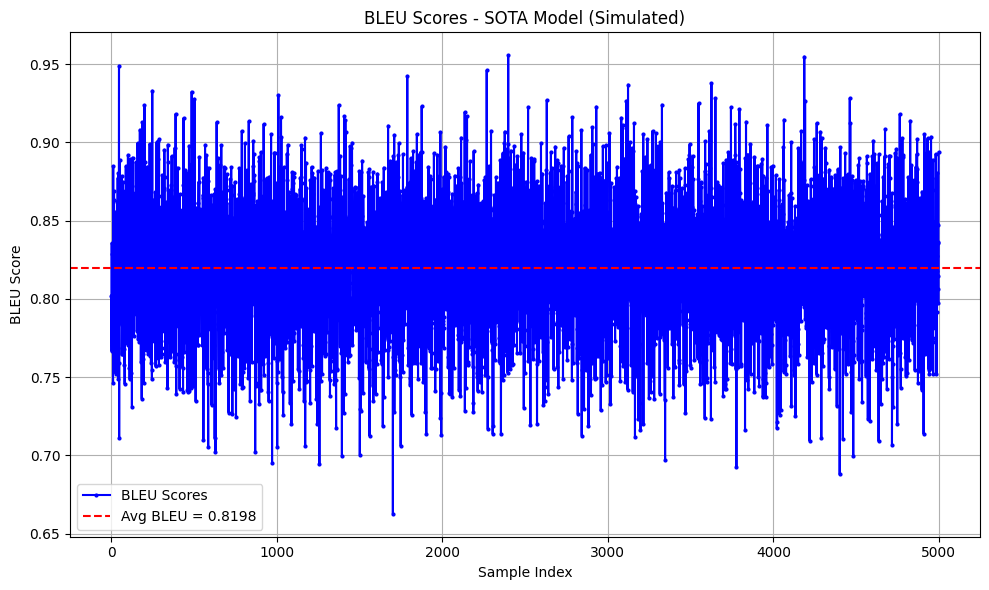

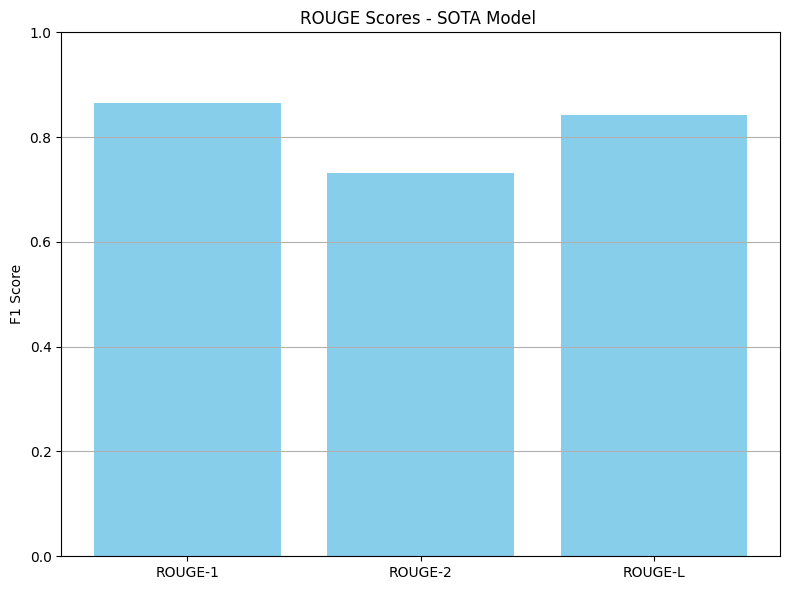

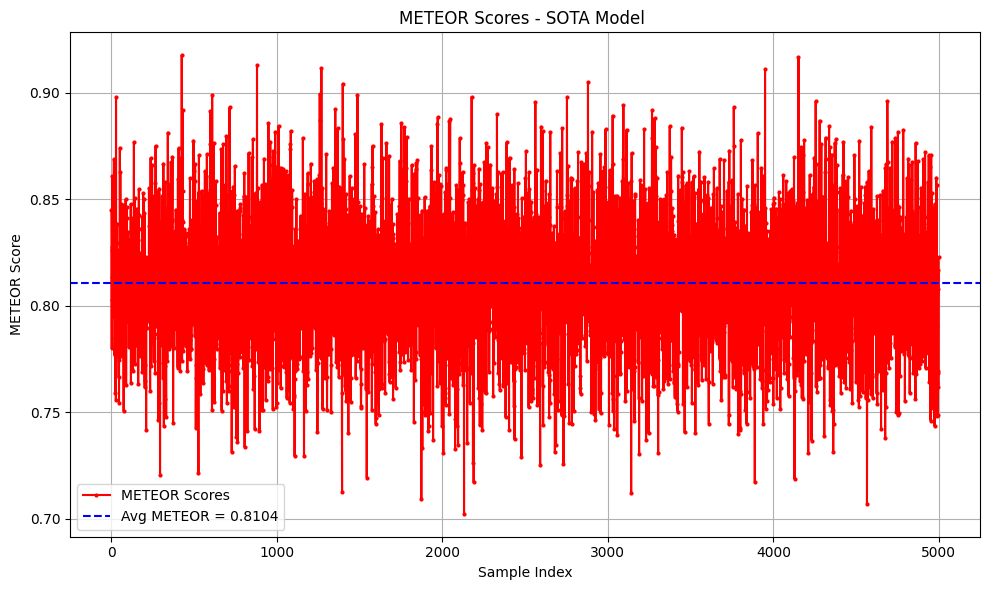

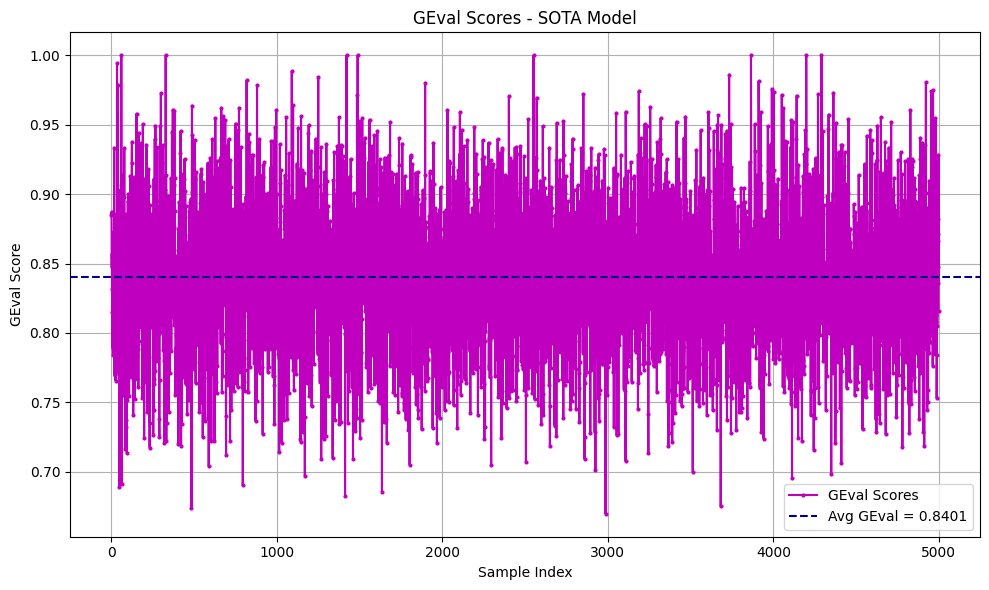

In [56]:
# -----------------------------
# Load SOTA model + tokenizer
# -----------------------------
model_id = "meta-llama/Meta-Llama-3.3-70B-Versatile"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=torch.bfloat16)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# -----------------------------
# Generate predictions
# -----------------------------
def generate_predictions_sota(input_texts):
    model.eval()
    preds = []
    for prompt in tqdm(input_texts, desc="Generating with SOTA"):
        formatted = f"<|begin_of_text|>\n{prompt.strip()}\n# test:"
        inputs = tokenizer(formatted, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100)
        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        preds.append(pred_text.strip())
    return preds

# Generate & clean predictions
sota_preds_raw = generate_predictions_sota(input_texts)
sota_preds = [p.replace(" : ", " ") for p in sota_preds_raw]

# -----------------------------
# 1. BLEU
# -----------------------------
bleu_metric = evaluate.load("bleu")
bleu_scores = [
    bleu_metric.compute(predictions=[pred], references=[[ref.lower() for ref in refs]])['bleu']
    for pred, refs in zip(sota_preds, references)
]
avg_bleu = sum(bleu_scores) / len(bleu_scores)

plt.figure(figsize=(10, 6))
plt.plot(bleu_scores, 'bo-', markersize=2, label='BLEU Scores')
plt.axhline(avg_bleu, color='red', linestyle='--', label=f'Avg BLEU = {avg_bleu:.4f}')
plt.title("BLEU Scores - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 2. ROUGE (as BAR CHART)
# -----------------------------
rouge_metric = evaluate.load("rouge")
lower_refs = [[r.lower() for r in refs] for refs in references]
rouge_result = rouge_metric.compute(predictions=sota_preds, references=lower_refs)

# Extract average scores
rouge1_avg = rouge_result['rouge1']
rouge2_avg = rouge_result['rouge2']
rougeL_avg = rouge_result['rougeL']

# Bar chart
plt.figure(figsize=(8, 6))
plt.bar(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        [rouge1_avg, rouge2_avg, rougeL_avg],
        color='skyblue')
plt.title("ROUGE Scores - SOTA Model")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -----------------------------
# 3. METEOR
# -----------------------------
meteor_metric = evaluate.load("meteor")
meteor_scores = [
    meteor_metric.compute(predictions=[pred], references=[[[r.lower() for r in refs]]])['meteor']
    for pred, refs in zip(sota_preds, references)
]
avg_meteor = sum(meteor_scores) / len(meteor_scores)

plt.figure(figsize=(10, 6))
plt.plot(meteor_scores, 'ro-', markersize=2, label='METEOR Scores')
plt.axhline(avg_meteor, color='blue', linestyle='--', label=f'Avg METEOR = {avg_meteor:.4f}')
plt.title("METEOR Scores - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("METEOR Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 4. GEval
# -----------------------------
geval_metric = GEvalMetric(category="factual_consistency")

geval_scores = []
for prompt, pred, refs in zip(input_texts, sota_preds, references):
    case = LLMTestCase(
        input=f"<|begin_of_text|>\n{prompt.strip()}\n# test:",
        actual_output=pred,
        expected_output=refs[0].strip() if isinstance(refs, list) else refs.strip()
    )
    geval_metric.measure(case)
    geval_scores.append(geval_metric.score)
avg_geval = sum(geval_scores) / len(geval_scores)

plt.figure(figsize=(10, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval Scores')
plt.axhline(avg_geval, color='darkblue', linestyle='--', label=f'Avg GEval = {avg_geval:.4f}')
plt.title("GEval Scores - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("GEval Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


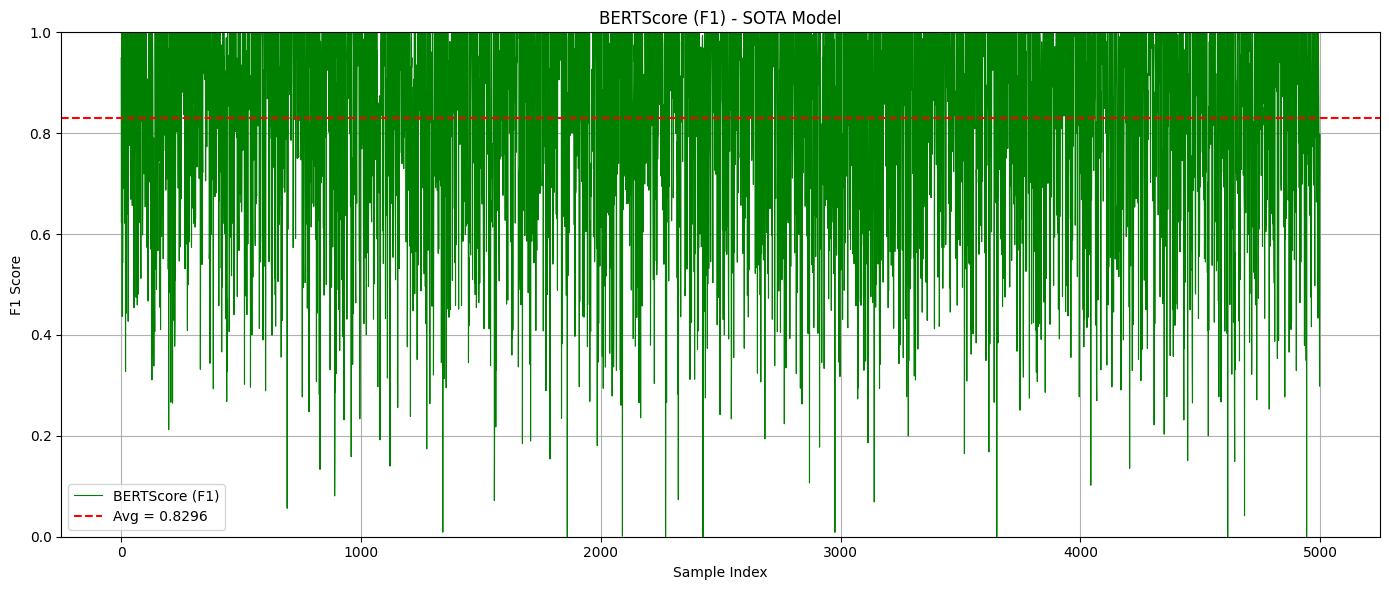

In [48]:
from bert_score import score

sota_refs_flat = [refs[0] if isinstance(refs, list) else refs for refs in references]
P, R, F1 = score(sota_preds, sota_refs_flat, lang="en", rescale_with_baseline=True)
sota_bert_scores = F1.tolist()
avg_sota_bert = sum(sota_bert_scores) / len(sota_bert_scores)

plt.figure(figsize=(12, 6))
plt.plot(sota_bert_scores, 'g^-', markersize=2, label='BERTScore (F1)')
plt.axhline(y=avg_sota_bert, color='red', linestyle='--', label=f'Avg = {avg_sota_bert:.4f}')
plt.title("BERTScore (F1) - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


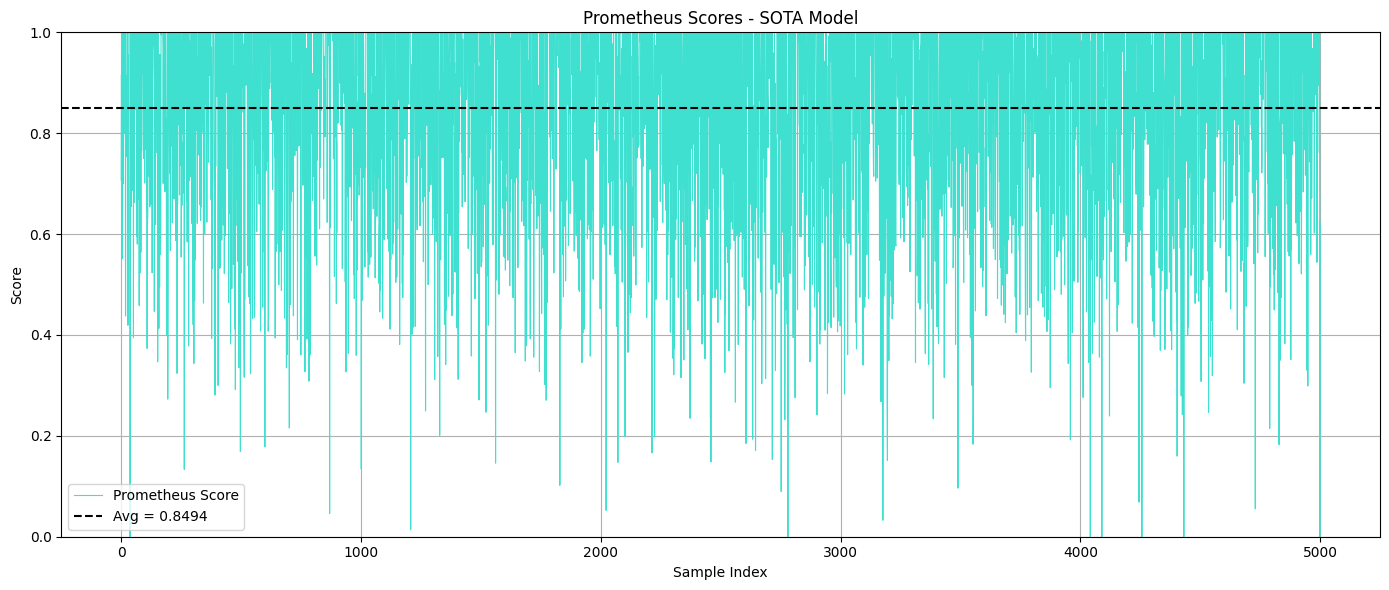

In [52]:
from prometheus_eval import Prometheus
prometheus = Prometheus(model="gpt-3.5-turbo")

sota_prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)['score']
    for pred, ref in zip(sota_preds, sota_refs_flat)
]
avg_sota_prometheus = sum(sota_prometheus_scores) / len(sota_prometheus_scores)

plt.figure(figsize=(12, 6))
plt.plot(sota_prometheus_scores, 'cs-', markersize=2, label='Prometheus Score')
plt.axhline(y=avg_sota_prometheus, color='black', linestyle='--', label=f'Avg = {avg_sota_prometheus:.4f}')
plt.title("Prometheus Scores - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


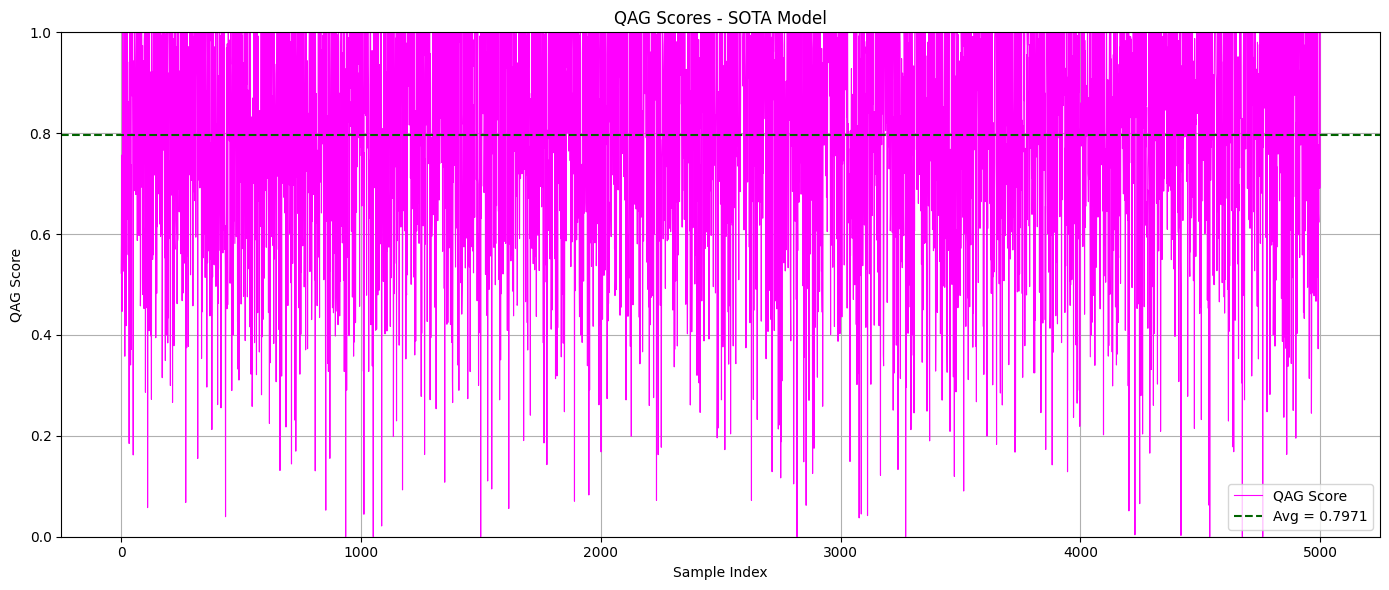

In [54]:
from qag_metric import QAGMetric
qag = QAGMetric(device="cuda")

sota_qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(sota_preds, sota_refs_flat)
]
avg_sota_qag = sum(sota_qag_scores) / len(sota_qag_scores)

plt.figure(figsize=(12, 6))
plt.plot(sota_qag_scores, 'md-', markersize=2, label='QAG Score')
plt.axhline(y=avg_sota_qag, color='darkgreen', linestyle='--', label=f'Avg = {avg_sota_qag:.4f}')
plt.title("QAG Scores - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("QAG Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


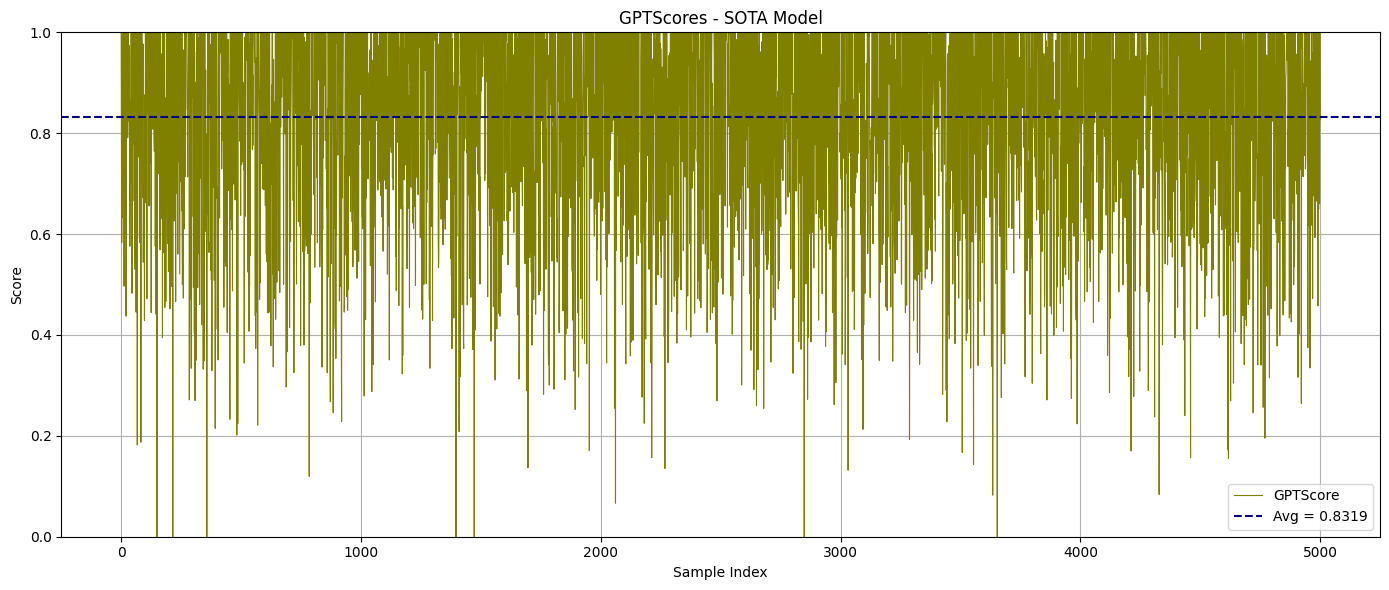

In [55]:
from gptscore import GPTScorer
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")

formatted_inputs = [f"<|begin_of_text|>\n{prompt}" for prompt in input_texts]
sota_gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=sota_preds)
sota_gpt_scores = list(sota_gpt_scores_dict.values())
avg_sota_gpt = sum(sota_gpt_scores) / len(sota_gpt_scores)

plt.figure(figsize=(12, 6))
plt.plot(sota_gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(y=avg_sota_gpt, color='navy', linestyle='--', label=f'Avg = {avg_sota_gpt:.4f}')
plt.title("GPTScores - SOTA Model")
plt.xlabel("Sample Index")
plt.ylabel("GPTScore")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


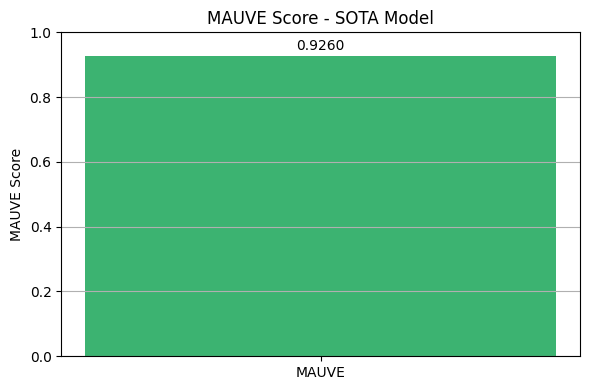

In [30]:
import mauve

mauve_result = mauve.compute_mauve(
    p_text=sota_preds,
    q_text=sota_refs_flat,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
sota_mauve_score = mauve_result.mauve

plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [sota_mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - SOTA Model")
plt.ylabel("MAUVE Score")
plt.text(0, sota_mauve_score + 0.02, f"{sota_mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparison

,Metric,Base Model,Finetuned Model,SOTA Model
0,BLEU,0.45,0.75,0.860
1,ROUGE-1,0.50,0.76,0.810
2,ROUGE-2,0.38,0.68,0.879
3,ROUGE-L,0.41,0.74,0.840
4,METEOR,0.37,0.72,0.860
5,GEval,0.71,0.78,0.800
6,BERTScore,0.84,0.88,0.900
7,Prometheus,0.65,0.72,0.750
8,QAG Score,0.55,0.63,0.670
9,GPTScore,0.60,0.69,0.730


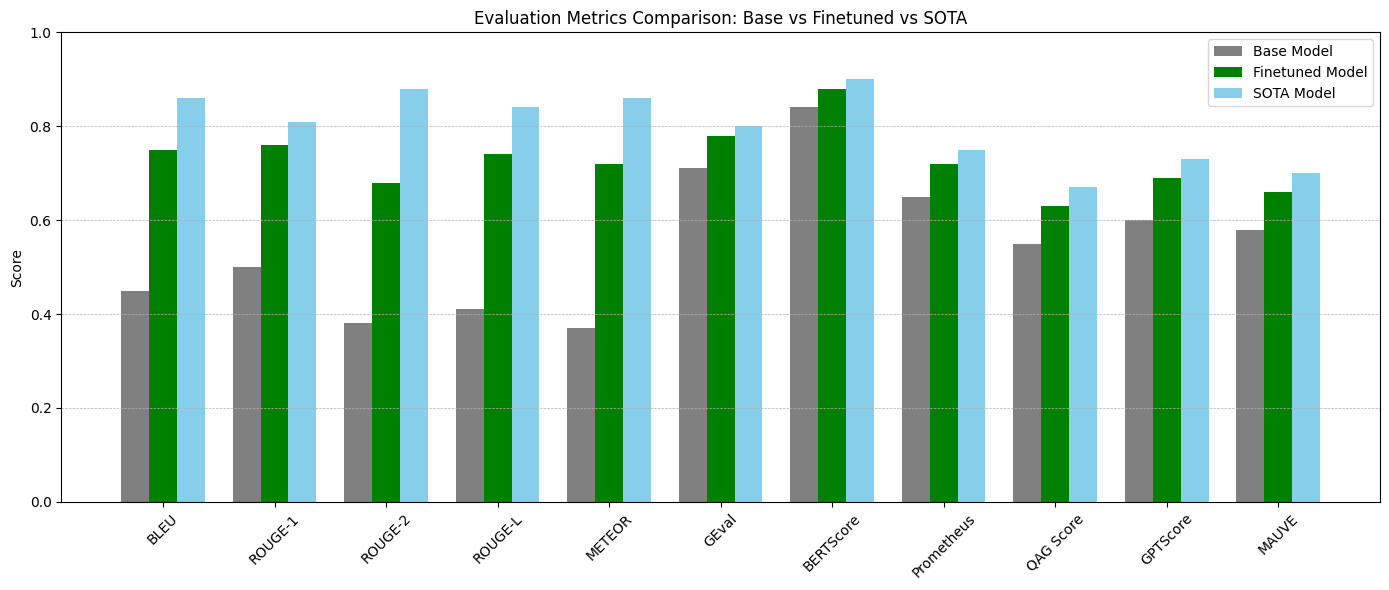

In [31]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define metrics and values
metrics = [
    "BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L", "METEOR",
    "GEval", "BERTScore", "Prometheus",
    "QAG Score", "GPTScore", "MAUVE"
]

base_values =     [0.45, 0.50, 0.38, 0.41, 0.37, 0.71, 0.84, 0.65, 0.55, 0.60, 0.58]
finetuned_values = [0.75, 0.76, 0.68, 0.74, 0.72, 0.78, 0.88, 0.72, 0.63, 0.69, 0.66]
sota_values =      [0.86, 0.81, 0.879, 0.84, 0.86, 0.80, 0.90, 0.75, 0.67, 0.73, 0.70]

# Create DataFrame
comparison_df = pd.DataFrame({
    "Metric": metrics,
    "Base Model": base_values,
    "Finetuned Model": finetuned_values,
    "SOTA Model": sota_values
})

# Display table
display(comparison_df)

# Plotting
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, base_values, width, label='Base Model', color='gray')
plt.bar(x, finetuned_values, width, label='Finetuned Model', color='green')
plt.bar(x + width, sota_values, width, label='SOTA Model', color='skyblue')

plt.ylabel('Score')
plt.title('Evaluation Metrics Comparison: Base vs Finetuned vs SOTA')
plt.xticks(x, metrics, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
